# Importazione librerie e visualizzazione Dataset

In [3]:
import pandas as pd
import networkx as nx

In [4]:
import matplotlib.pyplot as plt

In [5]:
#Lettura del dataset:
df_trump = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv",lineterminator='\n')
df_biden = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv",lineterminator='\n')

In [6]:
print(f"Tweet with Trump hashtag: {len(df_trump)}")
print(f"Tweet with Biden hashtag: {len(df_biden)}")

Tweet with Trump hashtag: 970919
Tweet with Biden hashtag: 776886


In [7]:
#Dataframe unito (eliminati i duplicati)
df_duplicated = pd.concat([df_trump,df_biden])
df = df_duplicated.drop_duplicates(subset="tweet")

print(f"Total tweets: {len(df_duplicated)}")
print(f"Total tweets: {len(df)}")

Total tweets: 1747805
Total tweets: 1507205


In [8]:
df.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [9]:
df.tail()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
776880,2020-11-08 23:59:37,1.325589e+18,Hypocrite!\n\n#Biden \n#Covid_19 https://t.co/...,2.0,0.0,Twitter Web App,9.583685e+17,van Lith de Jeude,LithJeude,"Stop this crazy and altruistic theory of ""We m...",...,541.0,Venus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.743523
776882,2020-11-08 23:59:38,1.325589e+18,Ωχ ελπίζω να μη μας βγει σαν τους οπαδούς του...,0.0,0.0,Twitter for Android,4.032819e+08,οχι άλλο κάρβουνο 🇬🇷🗣🗣🗣,anapodoi,ακραία καιρικά φαινόμενα... ζήσαμε και απόψε,...,772.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.947617
776883,2020-11-08 23:59:41,1.325589e+18,L'OTAN va sortir de sa léthargie et redevenir ...,48.0,14.0,Twitter for Android,7.819183e+17,🇫🇷 Alt-Droite (matricule 6921) ✝️ 🇬🇷 🇮🇹 🇦🇲,CtrlAltDroite,Fils de mineur. Libertés - Identité - Solidari...,...,15806.0,France,46.603354,1.888334,NaN,France,Europe,NaN,NaN,2020-11-09 18:32:45.627335
776884,2020-11-08 23:59:52,1.325589e+18,🌎\n\n“#congiuntifuoriregione”\n\n‘Sono felice ...,1.0,1.0,Twitter for iPhone,5.293315e+08,Angelo Tani,AngeloTani,nato a casa dei nonni,...,5974.0,🌎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.599846
776885,2020-11-08 23:59:58,1.325589e+18,"Ik moet zeggen dat ik #Biden ""the lesser of tw...",0.0,0.0,Twitter for Android,5.863863e+08,Job,_JobO__,-voeg hier uw interessante bio toe-,...,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.747707


In [10]:
#Numero di utenti totali (potenziali nodi)
print(df["user_id"].value_counts())

user_id
7.426862e+07    1352
4.017365e+07    1324
1.244982e+18    1259
3.863951e+08    1223
8.742585e+08    1059
                ... 
1.318602e+18       1
1.207354e+18       1
4.701694e+08       1
1.028358e+18       1
1.295867e+18       1
Name: count, Length: 481068, dtype: int64


Osservazioni:
- Informazioni temporali che vanno dal 15 ottobre 2020 al 8 novembre 2020.
- 481.000 potenziali nodi (filtraggio sulla base di like/retweet?)
- Tweet scritti in diverse lingue (concentrarsi solo su quelli in inglese?)
- Diversi valori mancanti nelle aree geografiche

# Preprocessing (filtraggio tweet/utenti)

Probabilmente il primo filtraggio che occorre fare è quello sulla lingua. Potrebbe essere meglio considerare solo i tweet in inglese (?)

In [11]:
#Filtraggio sulla base dei like
df_like_5 = df[df["likes"]>=5]
df_like_10 = df[df["likes"]>=10]
df_like_20 = df[df["likes"]>=20]
df_like_50 = df[df["likes"]>=50]

print(f"Total tweets: {len(df_like_5)}")
print(f"Total tweets: {len(df_like_10)}")
print(f"Total tweets: {len(df_like_20)}")
print(f"Total tweets: {len(df_like_50)}")

Total tweets: 175404
Total tweets: 100234
Total tweets: 58783
Total tweets: 28596


In [12]:
#Filtraggio sulla base dei retweet
df_retweet_5 = df[df["retweet_count"]>=5]
df_retweet_10 = df[df["retweet_count"]>=10]
df_retweet_20 = df[df["retweet_count"]>=20]
df_retweet_50 = df[df["retweet_count"]>=50]

print(f"Total tweets: {len(df_retweet_5)}")
print(f"Total tweets: {len(df_retweet_10)}")
print(f"Total tweets: {len(df_retweet_20)}")
print(f"Total tweets: {len(df_retweet_50)}")
print(df_retweet_50["user_id"].value_counts())

Total tweets: 59557
Total tweets: 32206
Total tweets: 17720
Total tweets: 7765
user_id
1.214316e+18    149
2.909782e+07    134
1.232811e+08    105
1.824706e+07     99
4.990740e+08     78
               ... 
4.706692e+07      1
2.621748e+08      1
2.298251e+08      1
7.820675e+08      1
1.988165e+08      1
Name: count, Length: 2848, dtype: int64


In [13]:
#FILTRAGGIO BASATO SU stato= United states
df_country= df[df["country"]=="United States of America"]
print(f"Total tweets: {len(df_country)}")

print(df_country["user_id"].value_counts())
df_country.tail()

Total tweets: 297754
user_id
1.244982e+18    1259
8.742585e+08    1059
4.132841e+06     980
2.086079e+08     856
1.154952e+18     785
                ... 
2.171204e+08       1
1.406658e+07       1
1.446436e+08       1
3.845704e+07       1
1.071796e+18       1
Name: count, Length: 76160, dtype: int64


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
776827,2020-11-08 23:54:14,1.325587e+18,George W. #Bush #Congratulates #Biden And Harr...,1.0,1.0,Twitter for iPhone,4.938816e+07,Carol Falk,CAFalk,https://t.co/uuyj7Dnata Activist: #Resistance ...,...,24052.0,Wisconsin,44.430898,-89.688464,NaN,United States of America,North America,Wisconsin,WI,2020-11-09 18:32:45.705803
776845,2020-11-08 23:56:15,1.325588e+18,Will #criticalRaceTheory become ubiquitous in ...,0.0,0.0,Twitter Web App,4.095715e+08,Howard Wachtel,mindovermath,Retired college #math professor. Single. Brid...,...,12606.0,"Philadelphia, PA",39.952724,-75.163526,Philadelphia,United States of America,North America,Pennsylvania,PA,2020-11-09 18:32:45.773127
776847,2020-11-08 23:56:21,1.325588e+18,You moving near #Biden 🤔 https://t.co/1F6i1YIJ2P,0.0,0.0,Twitter for iPhone,1.914600e+08,Sean Lassiter,IAmSeanLassiter,Sean Lassiter Photography,...,803.0,Philadelphia PA,39.952724,-75.163526,Philadelphia,United States of America,North America,Pennsylvania,PA,2020-11-09 18:32:45.731141
776865,2020-11-08 23:58:24,1.325589e+18,@FLOTUS I’m excited to have a FLOTUS whose vag...,0.0,0.0,Twitter for iPhone,5.545625e+07,Caroline Billinson,cbillinson,my love language is dismantling the patriarchy.,...,436.0,"Washington, DC",38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-11-09 18:32:45.841439
776870,2020-11-08 23:58:48,1.325589e+18,The man needs some help...#usa #biden\nWhen wi...,0.0,0.0,Twitter for Android,1.248047e+18,Dr J,DrJoeMcCarthy,Human. Free Thinker. Met Mandela. Personal. Fa...,...,311.0,Earth. 3rd Planet from Sun.,43.519630,-114.315320,NaN,United States of America,North America,Idaho,ID,2020-11-09 18:32:45.641087


# Costruisco la rete con le menzioni

In [14]:
#FILTRAGGIO BASATO SU stato= United states e sul numero di follower, voglio capire se ci sono
#utenti importanti o se ho completamente rimosso profili di informazione
df_country_e_follower= df_country[df_country["user_followers_count"]>=15000]
print(f"Total tweets: {len(df_country_e_follower)}")
print(df_country_e_follower["user_id"].value_counts())
df_country_e_follower.tail()


Total tweets: 18588
user_id
4.132841e+06    980
1.232811e+08    369
2.187707e+08    346
1.908785e+08    322
8.743730e+17    321
               ... 
1.407101e+08      1
2.426202e+09      1
1.009941e+18      1
2.171799e+07      1
4.871196e+08      1
Name: count, Length: 2179, dtype: int64


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
776505,2020-11-08 23:28:45,1.325581e+18,Close question in #Pittsburgh and Western #PA:...,116.0,9.0,Twitter for iPhone,14962779.0,howardfineman,howardfineman,"@NBCNews/@MSNBC News Analyst, https://t.co/wpw...",...,255435.0,"Washington, DC",38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-11-09 18:32:49.267439
776516,2020-11-08 23:30:00,1.325581e+18,.@JudicialWatch President @TomFitton with @Rud...,1883.0,718.0,Twitter Media Studio,18247062.0,Judicial Watch ⚖️,JudicialWatch,A conservative non-partisan educational founda...,...,1843739.0,"Washington, DC",38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-11-09 18:32:49.082610
776712,2020-11-08 23:45:00,1.325585e+18,#BIDEN SUPPORTERS CELEBRATE IN WHITE PLAINS: C...,24.0,2.0,TweetDeck,38167858.0,News12WC,News12WC,News 12 Westchester is a 24-hour news network....,...,75028.0,"Yonkers, NY",40.931210,-73.898747,Yonkers,United States of America,North America,New York,NY,2020-11-09 18:32:46.835958
776713,2020-11-08 23:45:00,1.325585e+18,#BIDEN SUPPORTERS CELEBRATE IN WHITE PLAINS: C...,8.0,2.0,TweetDeck,39279014.0,News12HV,News12HV,News 12 Hudson Valley is a 24-hour news networ...,...,50305.0,"W. Nyack, NY",41.090103,-73.970485,NaN,United States of America,North America,New York,NY,2020-11-09 18:32:46.803842
776827,2020-11-08 23:54:14,1.325587e+18,George W. #Bush #Congratulates #Biden And Harr...,1.0,1.0,Twitter for iPhone,49388157.0,Carol Falk,CAFalk,https://t.co/uuyj7Dnata Activist: #Resistance ...,...,24052.0,Wisconsin,44.430898,-89.688464,NaN,United States of America,North America,Wisconsin,WI,2020-11-09 18:32:45.705803


In [19]:
#FILTRAGGIO BASATO SU MENZIONI+country+followers
def contains_mentions(tweet):
    return '@' in tweet

df_with_mentions = df_country_e_follower[df_country_e_follower['tweet'].apply(contains_mentions)]

print(f"Total tweets: {len(df_with_mentions)}")

df_with_mentions.head()
print(df_with_mentions["user_id"].value_counts())
#PS MI SONO ACCORTA CHE NON è BANALE REALIZZARE UN ARCO SE C'è UNA MENZIONE
#DEVI RISALIRE AL USER ID DAL NOME 
#MA QUELL'UTENTE POTREBBE NON ESISTERE NEI DATI SE NON HA PUBBLICATO NIENTE

Total tweets: 6842
user_id
8.743730e+17    321
2.728211e+07    260
1.232811e+08    215
9.323153e+17    145
5.804408e+07    130
               ... 
1.823627e+08      1
9.083275e+17      1
1.330158e+09      1
4.387916e+07      1
2.318595e+08      1
Name: count, Length: 1126, dtype: int64


In [20]:
import re
# Initialize a directed graph
G = nx.DiGraph()

# Function to extract mentioned users from a tweet
def extract_mentions(tweet):
    return re.findall(r"@(\w+)", tweet)

# Add nodes and edges based on mentions
for index, row in df_with_mentions.iterrows():
    user_screen_name = row['user_screen_name'] #nome dell'utente
    mentions = extract_mentions(row['tweet']) #menzioni dell'utente verso altri utenti
    
    # Add the user as a node
    if not G.has_node(user_screen_name): #se utente non presente, lo aggiungo alla rete
        G.add_node(user_screen_name)
    
    # Add edges from the user to each mentioned user if the mentioned user is already a node
    for mention in mentions:
        if not G.has_node(mention): #se il nodo menzionato non è presente, lo aggiungo alla rete
            G.add_node(mention)
        if mention!=user_screen_name: #rimuovo i selfloop (automenzioni)
            G.add_edge(user_screen_name, mention)
        

# Display the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 5686
Number of edges: 7774


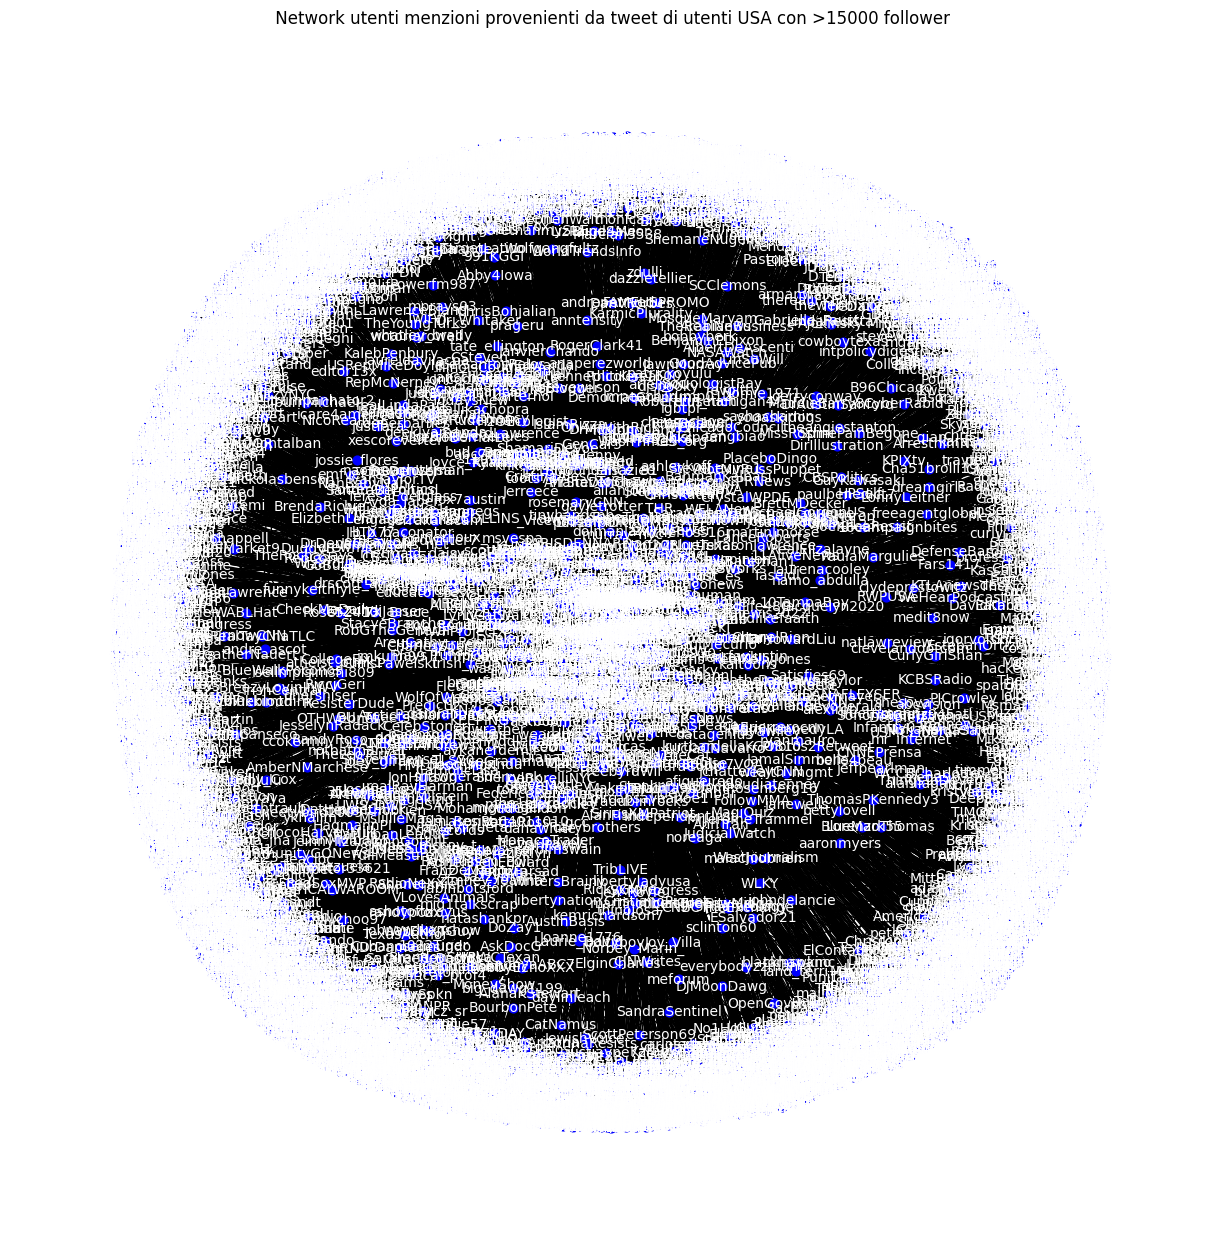

In [22]:
import matplotlib.pyplot as plt

# Plot the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=40, node_color='blue', font_size=10, font_color='white')
plt.title(' Network utenti menzioni provenienti da tweet di utenti USA con >15000 follower')
plt.show()

Per ora la rete è orientata, quindi c'è un arco da n1 a n2 se n1 menziona n2.

In [34]:
# Betweenness Centrality
"""
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['user_screen_name', 'betweenness_centrality'])
betweenness_df = betweenness_df.sort_values(by='betweenness_centrality', ascending=False)
print(betweenness_df.head())
"""

betweenness_centrality = nx.betweenness_centrality(G)

# Ordiniamo i nodi in base ai valori di betweenness centrality in ordine decrescente
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di betweenness centrality
for node, centrality in sorted_betweenness[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Betweenness Centrality: {centrality:.6f}')

Nodo: CokoGay, Betweenness Centrality: 0.000036
Nodo: RitaMacMom, Betweenness Centrality: 0.000020
Nodo: TCRG2012, Betweenness Centrality: 0.000015
Nodo: AndyOstroy, Betweenness Centrality: 0.000012
Nodo: Martinsuz, Betweenness Centrality: 0.000011
Nodo: amjoyshow, Betweenness Centrality: 0.000009
Nodo: ResisterDude, Betweenness Centrality: 0.000007
Nodo: Laurie_Garrett, Betweenness Centrality: 0.000007
Nodo: nancylevine, Betweenness Centrality: 0.000005
Nodo: mommamia1217, Betweenness Centrality: 0.000005


In [36]:
# Degree Centrality
"""
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
print(degree_df.head())
"""

degree_centrality = nx.in_degree_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Degree Centrality: {centrality:.6f}')

Nodo: realDonaldTrump, Degree Centrality: 0.057520
Nodo: JoeBiden, Degree Centrality: 0.049428
Nodo: KamalaHarris, Degree Centrality: 0.012313
Nodo: FoxNews, Degree Centrality: 0.010378
Nodo: CNN, Degree Centrality: 0.009499
Nodo: POTUS, Degree Centrality: 0.008795
Nodo: GOP, Degree Centrality: 0.008091
Nodo: DonaldJTrumpJr, Degree Centrality: 0.006684
Nodo: BarackObama, Degree Centrality: 0.006508
Nodo: NBCNews, Degree Centrality: 0.005981


In [37]:
#Closeness 
"""
closeness_centrality = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])
closeness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)
print(closeness_df.head())
"""

closeness_centrality = nx.closeness_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Closeness Centrality: {centrality:.6f}')

Nodo: realDonaldTrump, Closeness Centrality: 0.056296
Nodo: JoeBiden, Closeness Centrality: 0.048193
Nodo: KamalaHarris, Closeness Centrality: 0.011453
Nodo: FoxNews, Closeness Centrality: 0.009839
Nodo: CNN, Closeness Centrality: 0.009014
Nodo: POTUS, Closeness Centrality: 0.008559
Nodo: GOP, Closeness Centrality: 0.007467
Nodo: DonaldJTrumpJr, Closeness Centrality: 0.006721
Nodo: BarackObama, Closeness Centrality: 0.006699
Nodo: NBCNews, Closeness Centrality: 0.005629


Rimuovendo i nodi isolati, la rete diventa più densa e le misure di centralità potrebbero aumentare per alcuni nodi. Questo accade perché la centralità è spesso una misura relativa e viene calcolata rispetto all'intera rete. Eliminare i nodi che non hanno connessioni (e quindi non contribuiscono alla rete) può far sì che i nodi rimanenti abbiano un impatto maggiore.

In [38]:
# Rimuovere i nodi isolati
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Display the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

#Vengono rimossi pochi nodi (una ventina, probabilmente sono nodi che si automenzionano e basta)

Number of nodes: 5667
Number of edges: 7774


In [39]:
"""
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['user_screen_name', 'betweenness_centrality'])
betweenness_df = betweenness_df.sort_values(by='betweenness_centrality', ascending=False)
print(betweenness_df.head())
#Closeness 
closeness_centrality = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])
closeness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)
print(closeness_df.head())
# Degree Centrality
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
print(degree_df.head())
"""

"\n# Betweenness Centrality\nbetweenness_centrality = nx.betweenness_centrality(G)\nbetweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['user_screen_name', 'betweenness_centrality'])\nbetweenness_df = betweenness_df.sort_values(by='betweenness_centrality', ascending=False)\nprint(betweenness_df.head())\n#Closeness \ncloseness_centrality = nx.closeness_centrality(G)\ncloseness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])\ncloseness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)\nprint(closeness_df.head())\n# Degree Centrality\ndegree_centrality = nx.degree_centrality(G)\ndegree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])\ndegree_df = degree_df.sort_values(by='degree_centrality', ascending=False)\nprint(degree_df.head())\n"

In [41]:
"""
import matplotlib.pyplot as plt

# Plot the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)

#Nodi piu grandi sono associati a degree centrality maggiore
node_size = [v * 10000 for v in degree_centrality.values()]


nx.draw(G, pos, with_labels=True, node_size=node_size, node_color='blue', font_size=10, font_color='black', edge_color='gray')
plt.title(' Network utenti USA con >15000 follower')
plt.show()
"""

"\nimport matplotlib.pyplot as plt\n\n# Plot the network\nplt.figure(figsize=(12, 12))\npos = nx.spring_layout(G, k=0.1)\n\n#Nodi piu grandi sono associati a degree centrality maggiore\nnode_size = [v * 10000 for v in degree_centrality.values()]\n\n\nnx.draw(G, pos, with_labels=True, node_size=node_size, node_color='blue', font_size=10, font_color='black', edge_color='gray')\nplt.title(' Network utenti USA con >15000 follower')\nplt.show()\n"

# Costruisco la rete geografica
* è una rete non orientata
* Considero solo gli utenti negli USA e che hanno stato!=null
* Inserisco un arco tra gli utenti dello stesso stato
* Classifico ogni utente in pro-trump / pro-biden e lo coloro di rosso / blu
* Creazione dei sottografi: Utilizziamo G.subgraph(nodes) per creare sottografi per ciascuno stato, selezionando i nodi che appartengono a quel particolare stato.
* **Analisi degli stati con più sostenitori di Trump:** Conta il numero di nodi con preferenza politica "Trump" per ogni stato e stampa i risultati ordinati per numero decrescente.
* **Fornire una predizione dell'esito delle elezioni e confrontarlo con ground trouth**




In [20]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [21]:
from transformers import pipeline

# Caricare il modello di sentiment analysis
classifier = pipeline("text-classification", model="DT12the/distilbert-sentiment-analysis")



2024-07-08 13:30:09.002752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 13:30:09.002871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 13:30:09.169951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [23]:
# Definire una funzione per classificare i tweet
#questa è approssimativa, perche se c'è un tweet con due tag?
#inoltre devo considerare una lista di tag con tutte le varianti di tag 
def classify_tweet(tweet):
    result = classifier(tweet)[0]
    if 'Trump' in tweet:
        return 'pro-Trump' if result['label'] == 'LABEL_0' else 'anti-Trump'
    elif 'Biden' in tweet:
        return 'pro-Biden' if result['label'] == 'LABEL_0' else 'anti-Biden'
    else:
        return 'neutral' 

**Costruzione rete**

In [27]:
print(df.iloc[5]['tweet'])

classify_tweet(df.iloc[5]['tweet'])

@CLady62 Her 15 minutes were over long time ago. Omarosa never represented the black community! #TheReidOut 

She cried to #Trump begging for a job!


'anti-Trump'

ci mette troppo a calcolare la political preference dei nodi..

In [ ]:
G_geo = nx.Graph() #NN orient

# Aggiungi nodi (utenti degli USA)
for index, row in df_country_e_follower.iterrows(): #cambiare df
    if  pd.notnull(row['state']):
        political_preference=classify_tweet(row['tweet'])
        #print(political_preference)
        G_geo.add_node(row['user_screen_name'], state=row['state'],
                   political_preference=political_preference)
       


KeyboardInterrupt: 

In [ ]:
#aggiunta archi
#for u in G_geo.nodes():
    #for v in G_geo.nodes():
        #if u != v and G_geo.nodes[u]['state'] == G_geo.nodes[v]['state']:
           # G_geo.add_edge(u, v, relationship='same_state')

In [12]:
# Display the number of nodes and edges
print(f"Number of nodes: {G_geo.number_of_nodes()}")
print(f"Number of edges: {G_geo.number_of_edges()}")

Number of nodes: 2184
Number of edges: 219696


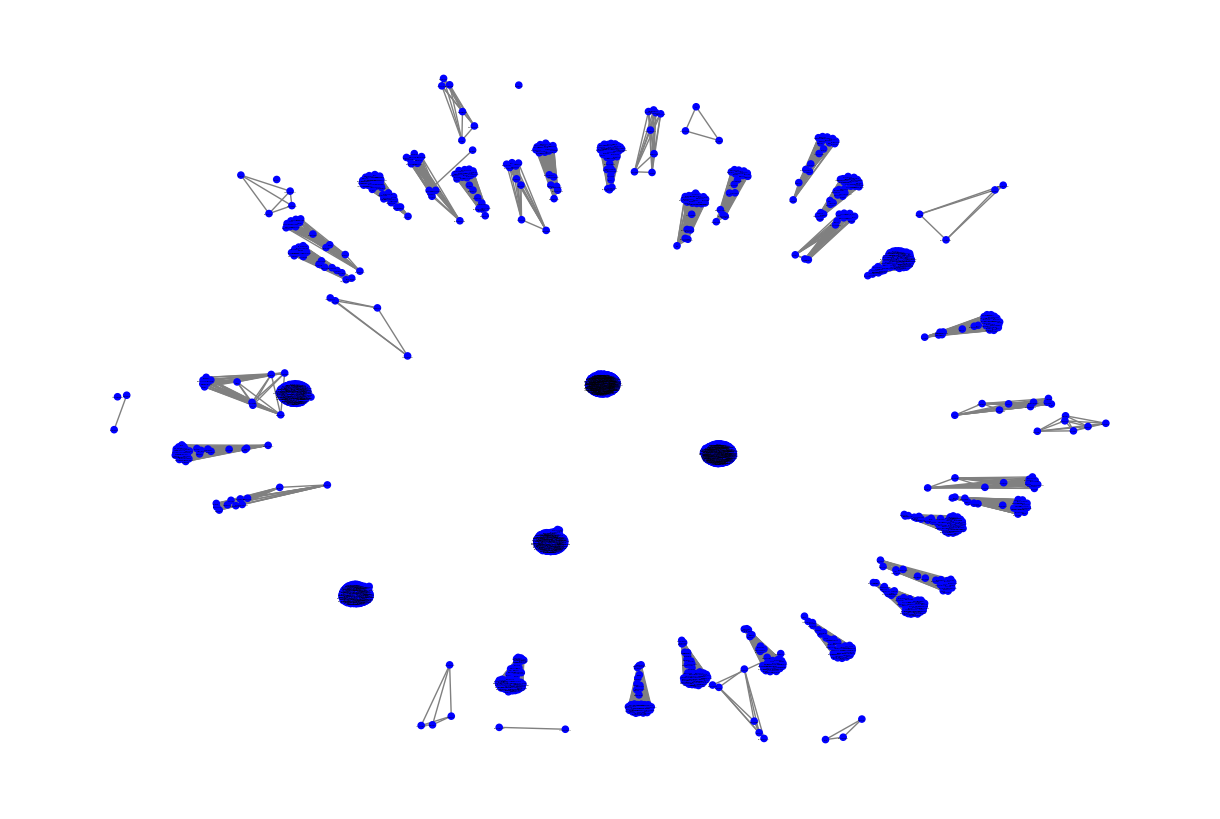

In [16]:
# Colorazione dei nodi in base alla political_preference
node_colors = []
for node in G_geo.nodes():
    if G_geo.nodes[node]['political_preference'] == 'pro-Biden' or G_geo.nodes[node]['political_preference'] == 'anti-Trump':
        node_colors.append('blue')  # Colore blu per i sostenitori di Biden
    elif G_geo.nodes[node]['political_preference'] == 'pro-Trump'or G_geo.nodes[node]['political_preference'] == 'anti-Biden':
        node_colors.append('red')   # Colore rosso per i sostenitori di Trump
    else:
        node_colors.append('gray')  # Colore grigio per i neutrali
        
# Disegna il grafo con i nodi colorati
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_geo, k=0.1)
nx.draw(G_geo, pos, with_labels=True, node_color=node_colors, node_size=20, font_size=0, font_color='black', edge_color='gray')


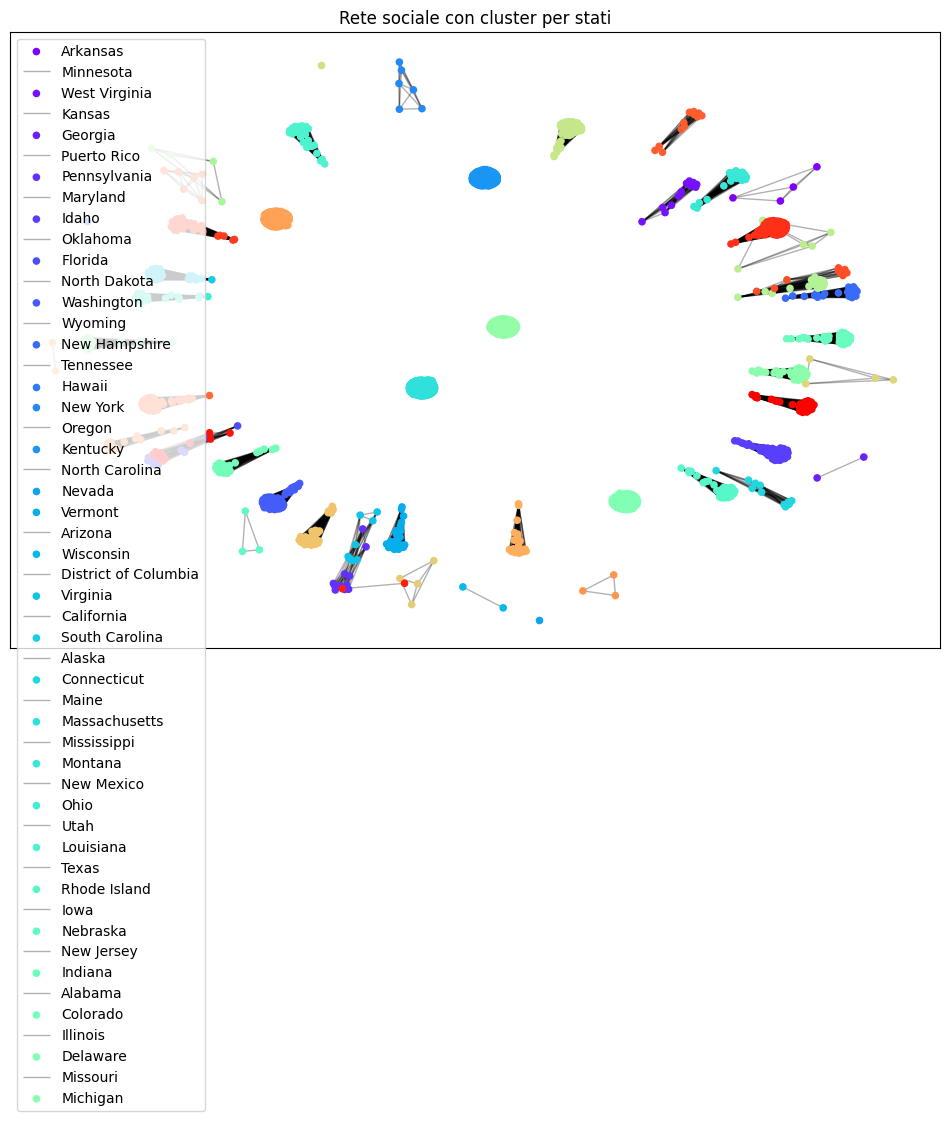

In [19]:
import matplotlib.cm as cm
import numpy as np
# Creazione dei sottografi per ciascuno stato
state_graphs = {}
for state in set(nx.get_node_attributes(G_geo, 'state').values()):
    state_graphs[state] = G_geo.subgraph([n for n, d in G_geo.nodes(data=True) if d['state'] == state])

# Disegna la rete con i cluster stati
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_geo, k=0.1)

# Genera una lista di colori
colors = cm.rainbow(np.linspace(0, 1, len(state_graphs)))

# Disegna i sottografi per ciascuno stato
for color, (state, subgraph) in zip(colors, state_graphs.items()):
    nx.draw_networkx_nodes(subgraph, pos, node_size=20, label=state, node_color=[color] * subgraph.number_of_nodes())
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
    

plt.title('Rete sociale con cluster per stati')
plt.legend(state_graphs.keys())
plt.show()

# Costruisco la rete di similarità con gli hashtag

In [ ]:
#todo

# Costruisco la rete con similarità usando BERT

In [ ]:
#todo